## Poster Plots

We will use this notebook to produce plots to use in the NeurIPS poster. We want to
have similar plots to the acquisition function presented in the paper.

These plots aim to motivate our approach, i.e., the value of selecting w, using a
simple toy example where it is safe to ignore a large part of the solution space.

In [4]:
# imports and problem setup
from copy import copy
import torch
from botorch.utils import draw_sobol_normal_samples, draw_sobol_samples
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from BoRisk.acquisition import InnerRho, rhoKG, rhoKGapx
from botorch.models.transforms import Standardize
from BoRisk.optimization.optimizer import Optimizer, InnerOptimizer
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 17

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

seed = 15
torch.manual_seed(seed)

dim_w = 1
num_samples = 10
num_restarts = 40
raw_multiplier = 50
maxiter = 1000
num_fantasies = 10
q = 1
num_inner_restarts = 10
inner_raw_multiplier = 5
tts_frequency = 1  # do not change

We want a simple function that is monotone in w.

In [5]:
def test_function(X: Tensor) -> Tensor:
    assert X.shape[-1] == 2
    x = X[..., :1]
    w = X[..., 1:]
    return (x-0.5).pow(2) + w.pow(2)
# Initialize the test function and fit GP
function = test_function
d = 2  # dimension of train_X
dim_x = d - dim_w  # dimension of the x component

n = 20

# train_X = draw_sobol_samples(
#     bounds = torch.tensor([[0., 0.], [1., 1.]]),
#     q=1,
#     n=n,
# ).squeeze(-2)
# train_X = torch.tensor([
#     [0.2, 0.2],
#     [0.2, 0.5],
#     [0.2, 0.8],
#     [0.5, 0.1],
#     [0.5, 0.35],
#     [0.5, 0.65],
#     [0.5, 0.9],
#     [0.9, 0.],
#     [0.9, 0.3],
#     [0.9, 0.7],
#     [0.9, 1.]
# ])
train_X = torch.rand(n, d)
train_Y = function(train_X)
train_Y = train_Y + torch.randn_like(train_Y) * 0.25

w_samples = torch.linspace(0, 1, num_samples).reshape(num_samples, 1)

gp = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
_ = fit_gpytorch_model(mll)

In [6]:
# initialize the optimizers
inner_optimizer = InnerOptimizer(
    num_restarts=num_inner_restarts,
    raw_multiplier=inner_raw_multiplier,
    dim_x=dim_x,
    maxiter=maxiter,
)

optimizer = Optimizer(
    num_restarts=num_restarts,
    raw_multiplier=raw_multiplier,
    num_fantasies=num_fantasies,
    dim=d,
    dim_x=dim_x,
    q=q,
    maxiter=maxiter,
)

In [7]:
# setup the acquisition functions and the posterior objective

fix_samples = True
fixed_samples = w_samples
alpha = 0.7
CVaR = True
num_repetitions = 40
fantasy_seed = int(torch.randint(10000, (1,)))
inner_seed = int(torch.randint(10000, (1,)))

inner_rho = InnerRho(
    model=gp,
    w_samples=w_samples,
    alpha=alpha,
    dim_x=dim_x,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
)

past_x = train_X[:, :dim_x]

current_best_sol, current_best_value = optimizer.optimize_inner(inner_rho)

rhokgapx = rhoKGapx(
    model=gp,
    num_samples=num_samples,
    alpha=alpha,
    current_best_rho=current_best_value,
    num_fantasies=num_fantasies,
    fantasy_seed=fantasy_seed,
    dim=d,
    dim_x=dim_x,
    past_x=past_x,
    q=q,
    fix_samples=fix_samples,
    fixed_samples=fixed_samples,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
    tts_frequency=tts_frequency
)

rhokg = rhoKG(
    model=gp,
    num_samples=num_samples,
    alpha=alpha,
    current_best_rho=current_best_value,
    num_fantasies=num_fantasies,
    fantasy_seed=fantasy_seed,
    dim=d,
    dim_x=dim_x,
    inner_optimizer=inner_optimizer.optimize,
    q=q,
    fix_samples=fix_samples,
    fixed_samples=fixed_samples,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
    tts_frequency=tts_frequency
)

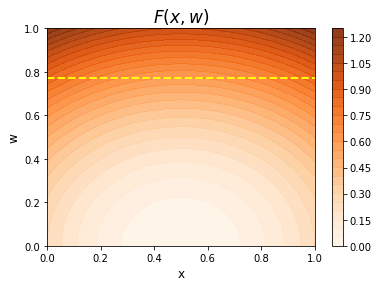

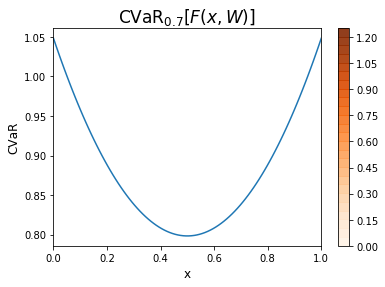

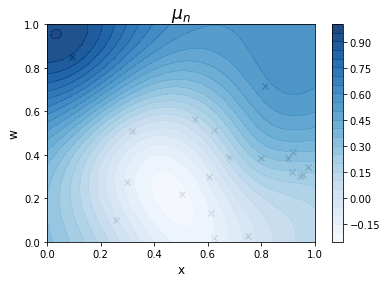

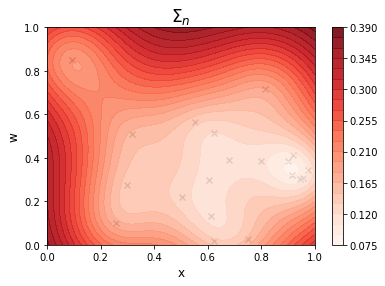

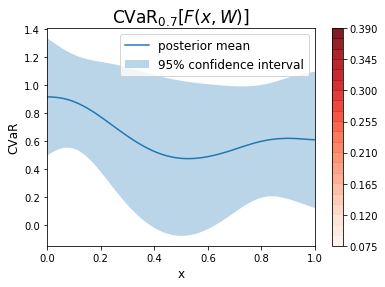

In [18]:
# Plot the statistical model
levels = 25
alp = 0.9
save_extension = "pdf"

# the objective function
fig, ax = plt.subplots()  # consider setting figsize
ax.set_ylabel("w")
ax.set_title("$F(x, w)$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
k = 100  # number of points in x and w
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
evals = function(xy).squeeze().detach().numpy()
cmap = "Oranges"
c = ax.contourf(xx, yy, evals, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
# shade the part that contributes to CVaR
plt.axhline(0.77, color='yellow', lw=2.0, ls="--")
plt.savefig("obj." + save_extension, dpi=300)
plt.show()

# plot cvar:
def cvar(x):
    w_cvar = w_samples[int(num_samples * alpha):]
    X = torch.cat([
        x.unsqueeze(-2).repeat(*[1]*(x.dim()-1), w_cvar.shape[0], 1),
        w_cvar.repeat(*x.shape[:-1], 1, 1)
    ], dim=-1)
    return torch.mean(function(X), dim=-2)

fig, ax = plt.subplots()  # consider setting figsize
ax.set_ylabel("CVaR")
ax.set_title("CVaR$_{0.7}$[$F(x, W)$]")
ax.set_xlabel("x")
ax.set_xlim(0, 1)

sols = torch.linspace(0, 1, k).view(-1, 1)
vals = cvar(sols)
ax.plot(sols.reshape(-1).numpy(), vals.numpy())
plt.colorbar(c, ax=ax)
plt.savefig("obj_cvar." + save_extension, dpi=300)
plt.show()


# GP posterior mean
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\mu_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot mu
k = 100  # number of points in x and w
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
means = gp.posterior(xy).mean.squeeze().detach().numpy()
cmap = "Blues"
c = ax.contourf(xx, yy, means, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("mu_n." + save_extension, dpi=300)
plt.show()

# GP posterior variance
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\Sigma_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot Sigma
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
stdevs = gp.posterior(xy).variance.pow(1 / 2).squeeze().detach().numpy()
cmap = "Reds"
c = ax.contourf(xx, yy, stdevs, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("Sigma_n." + save_extension, dpi=300)
plt.show()

# Implied posterior objective
fig, ax = plt.subplots()  # consider setting figsize
ax.set_ylabel("CVaR")
ax.set_title("CVaR$_{0.7}$[$F(x, W)$]")
ax.set_xlabel("x")
ax.set_xlim(0, 1)

sols = torch.linspace(0, 1, k).view(-1, 1)
vals = -inner_rho(sols)
# confidence intervals
alternate_inner = copy(inner_rho)
alternate_inner.num_repetitions = 1
alternate_inner.inner_seed = None
results = torch.empty((100, *vals.size()))
with torch.no_grad():
    for i in range(100):
        raw_sobol = draw_sobol_normal_samples(
            d=alternate_inner.num_samples,
            n=alternate_inner.num_fantasies,
            seed=alternate_inner.inner_seed,
        )
        alternate_inner.sobol_samples = raw_sobol.reshape(
            alternate_inner.num_repetitions,
            alternate_inner.num_fantasies,
            1,
            alternate_inner.num_samples,
            1,
        )
        results[i] = -alternate_inner(sols)
mean = torch.mean(results, dim=0).detach().reshape(-1)
std = torch.std(results, dim=0).detach().reshape(-1)
ax.plot(sols.reshape(-1).numpy(), mean.numpy(), label="posterior mean")
ax.fill_between(
    sols.reshape(-1), mean - 1.96 * std, mean + 1.96 * std,
    alpha=0.3, label="95% confidence interval"
)
plt.colorbar(c, ax=ax)
plt.legend()
plt.savefig("cvar." + save_extension, dpi=300)
plt.show()

In [17]:
# generate the data for acqf plots
def evaluate_on_grid(apx: bool, k: int = 40):
    r"""
    Evaluates the acquisition function value on a grid
    Args:
        apx: If True, plots rhoKGapx, else plots rhoKG
        k: number of points in x axis

    Returns:
        A three-tuple of contour plot args
    """
    x = torch.linspace(0, 1, k)
    y = w_samples.numpy()
    xx, yy = np.meshgrid(x, y)
    xy = torch.cat([torch.tensor(xx).unsqueeze(-1), torch.tensor(yy).unsqueeze(-1)], -1)
    res = torch.zeros((num_samples, k, 1))
    for i in range(num_samples):
        for j in range(k):
            X_outer = xy[i, j]
            if apx:
                res[i, j] = rhokgapx(X_outer)
            else:
                res[i, j] = rhokg(X_outer)
            # print("sol %d, %d complete, time: %s " % (i, j, time() - start))
    return xx, yy, res.detach().squeeze()

apx_evals = evaluate_on_grid(True)
rhokg_evals = evaluate_on_grid(False)

print("Successfully evaluated!")

Successfully evaluated!


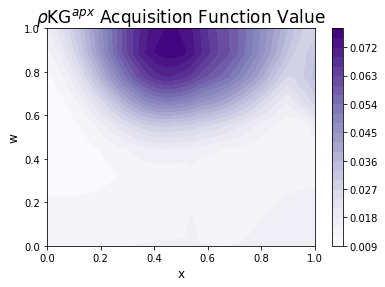

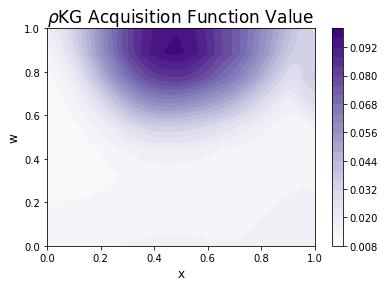

In [18]:
cmap = "Purples"
# produce the plots
for apx in [True, False]:
    plt.figure()
    plt.xlabel("x")
    plt.ylabel("w")
    if apx:
        plot_name = "$\\rho$KG$^{apx}$"
        data = apx_evals
        save_name = "rhoKGapx." + save_extension
    else:
        plot_name = "$\\rho$KG"
        data = rhokg_evals
        save_name = "rhoKG." + save_extension
    plt.title("%s Acquisition Function Value" % plot_name)
    c = plt.contourf(*data, levels=25, cmap=cmap)
    plt.colorbar(c)
    plt.savefig(save_name, dpi=300)
    plt.show()
